BEN ISSUE

Did not save the final model of the 50 repeats

the current model being loaded is the autokeras best model instead. but it gives sick results on test data so is annoying it cant be used to view training history. Could jsut sack the look at training history and use this final autokeras model, bear in mind it measn autokeras will always need installing to load it. See: https://stackoverflow.com/questions/54333833/do-we-need-final-fit-in-autokeras

Should be able to remove autokeras install if I switch back to final model


the 50 run autokeras one was better than the 25 run one and the 0.9995 one

- 25 reproducinle final model: 17 fp, 25 fn
- 25 reproducible autokeras model: 17 fp, 21 fn
- 50 final model: did not save ffs
- 50 autokeras model: 5 fp, 7 fn
- both  .9995 models were crap
could try: refitting the models (e.g the 25 reproducible). best thing though I think is try 50 repeats again under the reproducible mode (though this doesnt matter loads tbh just a model that works is all I need! Maybe move on

# Assess performance

This new script is used to assess the performance of the final model. A new notebook has been created to move away from the GPU instance.

1. Load the saved model and reinference on the dataset
2. View confusion matrices of the val and test data
3. Plot Area under precision-recall curve
3. Find misclassified files, view mel spectrograms of these



In [ ]:
# Downgrade tensorflow - run this cell, restart the runtime then no need to run this cell again
!pip install tensorflow==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# check the downgraded version of tf is installed, should print 2.8.3
import tensorflow as tf
print(tf.__version__)

2.8.3


In [ ]:
# Install autokeras - still required for loading the model
!pip install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Connect GDrive - click yes to all requests
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set paths to saved files and dirs
pickle_file_dir = "/content/drive/MyDrive/bombs/data/final_dataset/" # where test pickle file and model files are saved
checkpoint_path = "/content/drive/MyDrive/bombs/data/final_dataset/autokeras_best_model/best_model" # saved model, path may be in the sub folder 'best_model'
test_dir = "/content/drive/MyDrive/bombs/data/final_dataset/test_data/" # for inspecting files which are misclassified
#checkpoint_path = "/content/drive/MyDrive/bombs/data/final_dataset/autokeras_best_model/best_model" # saved model, path may be in the sub folder 'best_model'
#history_pickle_file = "/content/drive/MyDrive/bombs/data/final_dataset/final_model_history.pkl" # history_pickle_file
seed = 123
sample_rate = 8000 # for viewing specs 

In [ ]:
# tf and keras imports
from tensorflow.keras.models import load_model
import keras
import autokeras
import sklearn
import sklearn.model_selection

# import general packages
import os
import pickle
import numpy as np
import pandas as pd

# import some packages used for plottinig
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# for viewing sepcs of misclassified files
import librosa
import librosa.display

## Load the data

In [ ]:
# find the training file
pickle_file_name = "train_features_labels.pickle"
pickle_file_path = os.path.join(pickle_file_dir, pickle_file_name)

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    train_features, train_labels, input_shape = pickle.load(f)

# Split the data into training and validation sets (be sure to use same random state as the previous script)
train_features, val_features, train_labels, val_labels = sklearn.model_selection.train_test_split(train_features, train_labels, test_size=0.15, random_state=seed)

# print index of bombs
print('Number of samples: ' + str(len(train_labels)))
print()
print('Input shape for network: ' + str(input_shape))
print()
print('Number of bomb files: ' + str(len((np.where(train_labels == 1))[0])))

Number of samples: 15963

Input shape for network: (32, 46, 1)

Number of bomb files: 1516


In [ ]:
# find the test file
pickle_file_name = "test_features_labels.pickle"
pickle_file_path = os.path.join(pickle_file_dir, pickle_file_name)

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    test_features, test_labels, input_shape = pickle.load(f)

# print index of bombs
print('Number of samples: ' + str(len(test_labels)))
print()
print('Input shape for network: ' + str(input_shape))
print()
print('Number of bomb files: ' + str(len((np.where(test_labels == 1))[0])))

Number of samples: 1250

Input shape for network: (32, 46, 1)

Number of bomb files: 250


## Load the saved model

Inference on all data

In [ ]:
# load the model
# THIS CHECKPOINT PATH IS WRONG, IT LEADS TO BEST AUTOKERAS MODEL NOT FINAL MODEL
best_model = load_model(checkpoint_path)

# Load training history pickle file  - if getting 'bad zip file error' check the tensorflow downgrade was run at the start
#pickle_file_path = os.path.join(pickle_file_dir, history_pickle_file)
#with open(pickle_file_path, 'rb') as f:
 #   final_model_history = pickle.load(f)

best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 46, 1)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 46, 1)        0         
 t32)                                                            
                                                                 
 conv2d (Conv2D)             (None, 30, 44, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 42, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 21, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 21, 32)        0     

In [ ]:
# re-inference on the validation data
print('Train data')
train_raw_predictions = best_model.predict(train_features)
train_evaluation = best_model.evaluate(train_features, train_labels, verbose=1)

# re-inference on the validation data
print('Validation data')
val_raw_predictions = best_model.predict(val_features)
val_evaluation = best_model.evaluate(val_features, val_labels, verbose=1)

# inference on the test data
print('Test data')
test_raw_predictions = best_model.predict(test_features)
test_evaluation = best_model.evaluate(test_features, test_labels, verbose=1)

Train data
499/499 [==============================] - 26s 49ms/step - loss: 0.0254 - tp: 1506.0000 - fp: 81.0000 - tn: 14366.0000 - fn: 10.0000 - accuracy: 0.9943 - precision: 0.9490 - recall: 0.9934 - auc: 0.9998 - prc: 0.9980
Validation data
89/89 [==============================] - 7s 73ms/step - loss: 0.0292 - tp: 264.0000 - fp: 19.0000 - tn: 2534.0000 - fn: 0.0000e+00 - accuracy: 0.9933 - precision: 0.9329 - recall: 1.0000 - auc: 0.9999 - prc: 0.9987
Test data
40/40 [==============================] - 2s 40ms/step - loss: 0.0452 - tp: 243.0000 - fp: 5.0000 - tn: 995.0000 - fn: 7.0000 - accuracy: 0.9904 - precision: 0.9798 - recall: 0.9720 - auc: 0.9949 - prc: 0.9903


# Plotting

In [ ]:
# Set plot sixes and colours
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# define some plotting functions

# confusion matrix
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  
# AUC for precision recall curve
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

Validation data
loss :  0.029194675385951996
tp :  264.0
fp :  19.0
tn :  2534.0
fn :  0.0
accuracy :  0.9932552576065063
precision :  0.9328621625900269
recall :  1.0
auc :  0.9998657703399658
prc :  0.9987451434135437



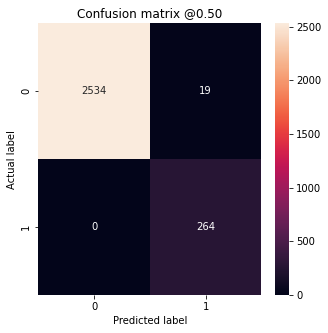

In [ ]:
# print some stats
print("Validation data")
for name, value in zip(best_model.metrics_names, val_evaluation):
  print(name, ': ', value)
print()

# plot test confusion matrix
plot_cm(val_labels, val_raw_predictions)

# final model: fp = 32, fn = 4
# autokeras = 19, 0

Test data
loss :  0.04517058655619621
tp :  243.0
fp :  5.0
tn :  995.0
fn :  7.0
accuracy :  0.9904000163078308
precision :  0.9798387289047241
recall :  0.972000002861023
auc :  0.9949380159378052
prc :  0.9902741312980652



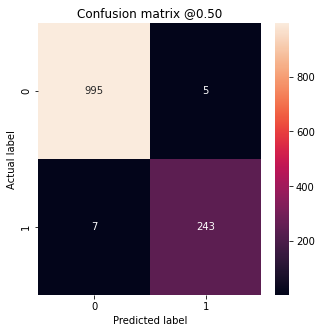

In [ ]:
print("Test data")
# print some stats
for name, value in zip(best_model.metrics_names, test_evaluation):
  print(name, ': ', value)
print()

# plot test confusion matrix
plot_cm(test_labels, test_raw_predictions)

# final_mdoel = fp = 8, fn = 13
# autokeras = 5, 7

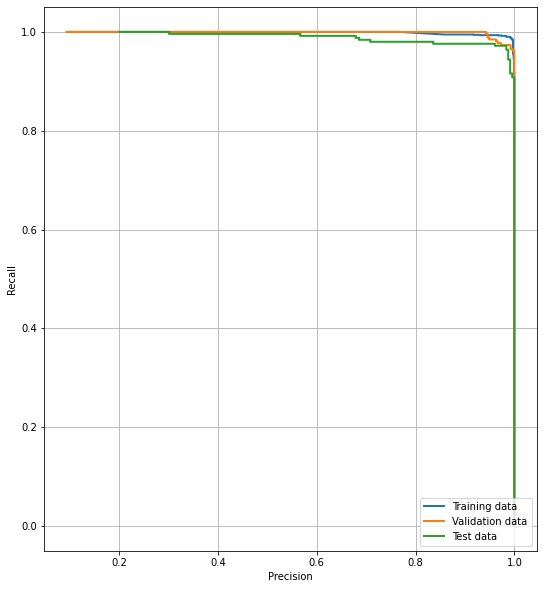

In [ ]:
# AUC for the precision recall curve - this shows keeping the default cut off value (0.5) is best, as moddifying this would not produce a lot of FP's for every TP gained
plot_prc("Training data", train_labels, train_raw_predictions, color=colors[0])
plot_prc("Validation data", val_labels, val_raw_predictions, color=colors[1])
plot_prc("Test data", test_labels, test_raw_predictions, color=colors[2])
plt.legend(loc='lower right');

# Inspect files which were misclassified

In [ ]:
false_negatives

array([1001, 1006, 1040, 1042, 1044, 1045, 1049])

In [ ]:
false_negative_filenames = np.array(sorted_test_files)[false_negatives]
false_negative_filenames

array(['YB00013_M02_20220901_082000_augmented6.wav',
       'YB00013_M02_20220901_082000_augmented1.wav',
       'YB00049_M06_20220914_124800_augmented5.wav',
       'YB00049_M06_20220914_124800_augmented7.wav',
       'YB00049_M06_20220914_124800_augmented9.wav',
       'YB00049_M06_20220914_124800.wav',
       'YB00049_M06_20220914_124800_augmented4.wav'], dtype='<U42')

In [ ]:
# get class predictions of test data, convert from boolean to 0 or 1
cut_off = 0.5
test_class_predictions = (test_raw_predictions > cut_off).astype(int)

# get index of predicted bombs and the true labels
predicted_bombs = np.where(test_class_predictions == 1)[0]
true_y_bombs = np.where(test_labels == 1)[0] # get indexes of test data y_bombs
true_n_boms = np.where(test_labels == 0)[0] # get indexes of test data n_bombs

# now find the index of misclassified files
false_negatives = np.setdiff1d(true_y_bombs, predicted_bombs)
false_positives = np.setdiff1d(predicted_bombs, true_y_bombs)

# list all the audio files in the directory
test_files = [f for f in os.listdir(test_dir) if f.endswith('.wav') or f.endswith('.WAV')]

# set the order of the test files (sometimes it comes out jumbled). Start with NB files, with lowest numbers first
def custom_sort_key(string):
    if string.startswith('NB'):
        return (0, int(string[2:7]))
    elif string.startswith('YB'):
        return (1, int(string[2:7]))
    else:
        raise ValueError(f"Unexpected string format: {string}")

sorted_test_files = sorted(test_files, key=custom_sort_key)

# finally, find file name of false negs and false pos
false_negative_filenames = np.array(sorted_test_files)[false_negatives]
false_positive_filenames = np.array(sorted_test_files)[false_positives]

print("Total number of bombs in data: " + str(len(true_y_bombs)))
print()
print("List of false negatives (bombs which were missed):")
print(false_negative_filenames)
print("Length: " + str(len(false_negative_filenames)))
print()
print("List of false positives:")
print(false_positive_filenames)
print("Length: " + str(len(false_positive_filenames)))

Total number of bombs in data: 250

List of false negatives (bombs which were missed):
['YB00013_M02_20220901_082000_augmented6.wav'
 'YB00013_M02_20220901_082000_augmented1.wav'
 'YB00049_M06_20220914_124800_augmented5.wav'
 'YB00049_M06_20220914_124800_augmented7.wav'
 'YB00049_M06_20220914_124800_augmented9.wav'
 'YB00049_M06_20220914_124800.wav'
 'YB00049_M06_20220914_124800_augmented4.wav']
Length: 7

List of false positives:
['NB01582_M03_20220911_211000_augmented1.wav'
 'NB02433_M14_20220921_122600_augmented1.wav'
 'NB03926_M08_20220910_140600_augmented1.wav'
 'NB05398_M11_20220920_133600.WAV'
 'NB06968_M12_20220907_150400_augmented1.wav']
Length: 5


In [ ]:
def view_multiple_mel_spec(filename_list, sr, audio_dir):
  """Creates a spectrogram plot of multiple audio files in the mel scale.
  Pass in the list of filenames as strings and the sample rate as an integer."""

  #set hop length for mel_spec and.specshow()
  hop_length = 64

  n = len(filename_list)
  
  # create a figure with n subplots, where n is the number of files in the list
  fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
  
  # iterate over the list of filenames
  for i, filename in enumerate(filename_list):
    file_path = audio_dir + filename
    audio, sample_rate = librosa.load(file_path, sr = sr)

    # compute the mel spectrogram of the audio
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128,
                                              win_length=1024, hop_length=hop_length)

    # convert the power spectrogram to decibel (dB) units 
    mel_spec_db = librosa.power_to_db(S=mel_spec, ref=1.0) 

    # plot the spectrogram for each file in a separate subplot
    librosa.display.specshow(mel_spec_db, sr=sample_rate, ax=ax[i],
                             y_axis='mel', x_axis='time',  
                             vmin = -100, vmax = 0, 
                             cmap = 'magma', hop_length=hop_length)
    ax[i].set_yticks([200, 500, 1000, 2000, 4000])
    ax[i].set_ylim(0,4000)

  # create the colorbar for the last plot only
  cbar = fig.colorbar(ax[-1].collections[0], ax=ax, orientation='vertical')

Viewing:
['YB00013_M02_20220901_082000_augmented6.wav'
 'YB00013_M02_20220901_082000_augmented1.wav'
 'YB00049_M06_20220914_124800_augmented5.wav'
 'YB00049_M06_20220914_124800_augmented7.wav'
 'YB00049_M06_20220914_124800_augmented9.wav'
 'YB00049_M06_20220914_124800.wav'
 'YB00049_M06_20220914_124800_augmented4.wav']


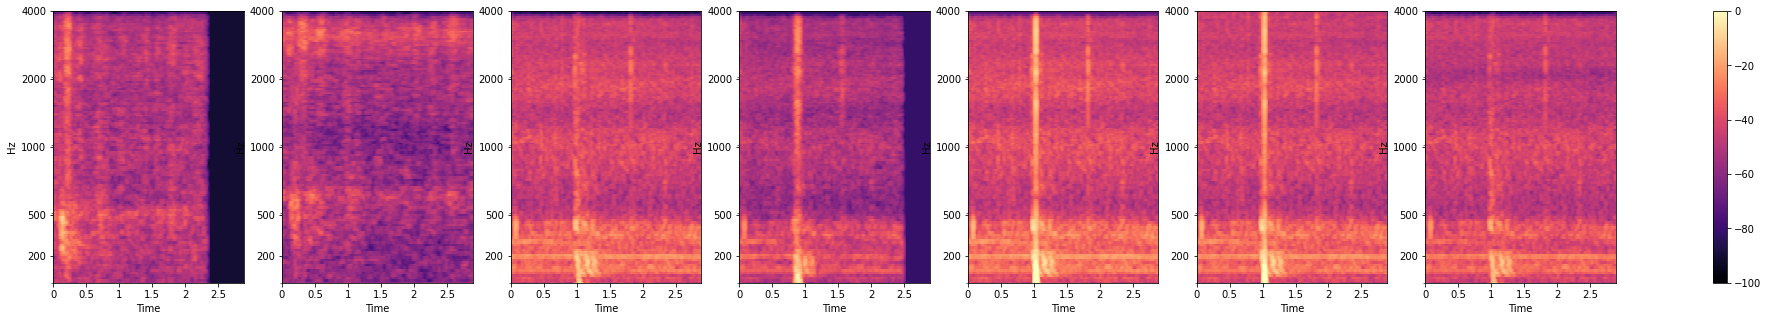

In [ ]:
print('Viewing:')
print(false_negative_filenames) # adjust index to view different files
view_multiple_mel_spec(false_negative_filenames, sample_rate, test_dir)

# notes - YB00049 is masked by boat noise
# YB00013 is genuinely really hard ot hear as bomb compared to other files

Viewing:
['NB01582_M03_20220911_211000_augmented1.wav'
 'NB02433_M14_20220921_122600_augmented1.wav'
 'NB03926_M08_20220910_140600_augmented1.wav'
 'NB05398_M11_20220920_133600.WAV'
 'NB06968_M12_20220907_150400_augmented1.wav']


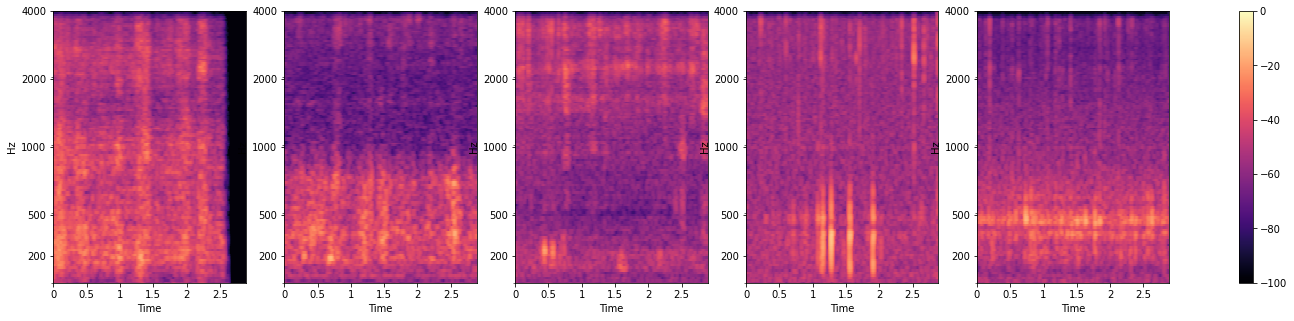

In [ ]:
print('Viewing:')
print(false_positive_filenames) # adjust index to view different files
view_multiple_mel_spec(false_positive_filenames, sample_rate, test_dir)

## For sanity, here are some unagmented bombs files that were correctly found:

View some true postive files:
['YB00013_M02_20220901_082000.wav', 'YB00027_M03_20220906_165800.wav', 'YB00031_M04_20220908_170600.wav', 'YB00034_M04_20220911_093600.wav', 'YB00057_M07_20220915_121000.wav', 'YB00062_M08_20220915_165600.wav', 'YB00065_M08_20220919_115400.wav', 'YB00067_M08_20220919_134600.wav']


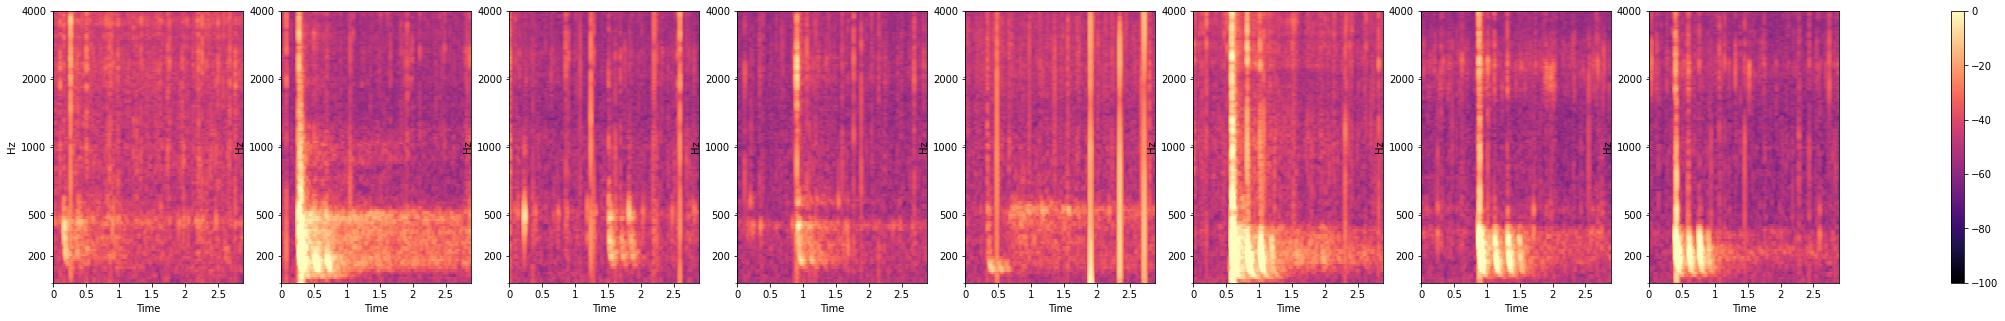

In [ ]:
# find true positives
true_positives = np.intersect1d(predicted_bombs, true_y_bombs)

# finally, find file name of false negs and false pos
true_positive_filenames = np.array(sorted_test_files)[true_positives]

# pick some unaugmented bomb files - pick every 10th file as the other 9 are augmented files)
unaugmented_files = [item for item in true_positive_filenames if 'augment' not in item]

# plot
print('View some true positive files:')
# adjust index to view different files, e.g 0:8 shows first 8 only
print(unaugmented_files[0:8]) 
view_multiple_mel_spec(unaugmented_files[0:8], sample_rate, test_dir)

BELOW IS JUNK

add this if I was using history from a final model

In [ ]:
# define some funstions to view training history, code used from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

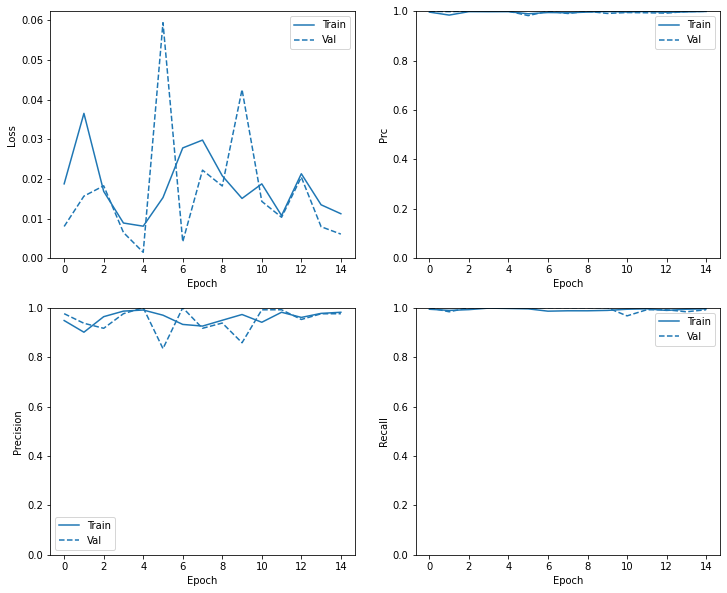

In [ ]:
plot_metrics(final_model_history)